In [40]:
import os
import tarfile
from mxnet import gluon
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import autograd, gluon, image, nd
from time import time
from mxnet.gluon import nn, data as gdata, loss as gloss, utils as gutils

In [6]:
data_root = './data'
voc_root = data_root + '/VOCdevkit/VOC2012'
url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
       '/VOCtrainval_11-May-2012.tar')
sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'

fname = gluon.utils.download(url, data_root, sha1_hash=sha1)

if not os.path.isfile(voc_root+'/ImageSets/Segmentation/train.txt'):
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_root)

In [7]:
from mxnet import image

def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + (
        'train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    n = len(images)
    data, label = [None] * n, [None] * n
    for i, fname in enumerate(images):
        data[i] = image.imread('%s/JPEGImages/%s.jpg' % (
            root, fname))
        label[i] = image.imread('%s/SegmentationClass/%s.png' % (
            root, fname))
    return data, label

def show_images(imgs, nrows, ncols, figsize=None):
    """plot a list of images"""
    if not figsize:
        figsize = (ncols, nrows)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            figs[i][j].imshow(imgs[i*ncols+j].asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

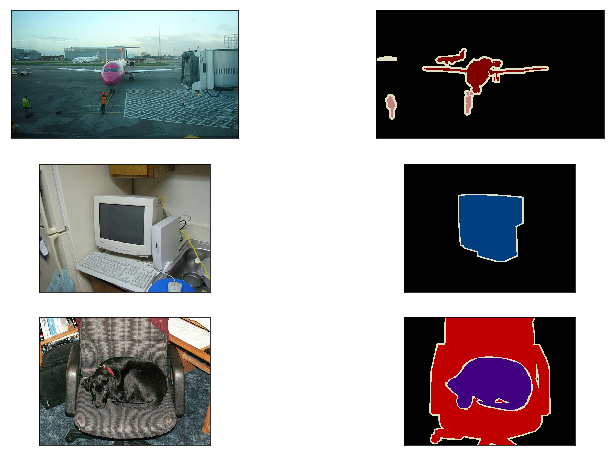

[(281, 500, 3),
 (281, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3)]

In [8]:
import sys
sys.path.append('..')

train_images, train_labels = read_images()

imgs = []
for i in range(3):
    imgs += [train_images[i], train_labels[i]]

show_images(imgs, nrows=3, ncols=2, figsize=(12,8))
[im.shape for im in imgs]

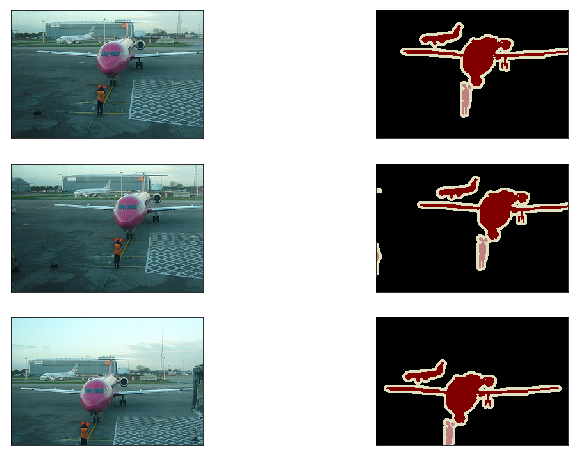

In [9]:
def rand_crop(data, label, height, width):
    data, rect = image.random_crop(data, (width, height))
    label = image.fixed_crop(label, *rect)
    return data, label

imgs = []
for _ in range(3):
    imgs += rand_crop(train_images[0], train_labels[0],
                      200, 300)

show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

In [10]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [11]:
import numpy as np
from mxnet import nd

cm2lbl = np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i

def image2label(im):
    data = im.astype('int32').asnumpy()
    idx = (data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return nd.array(cm2lbl[idx])

In [12]:
y = image2label(train_labels[0])
y[105:115, 130:140]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
<NDArray 10x10 @cpu(0)>

In [13]:
from mxnet import gluon
from mxnet import nd


rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def normalize_image(data):
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

class VOCSegDataset(gluon.data.Dataset):

    def _filter(self, images):
        return [im for im in images if (
            im.shape[0] >= self.crop_size[0] and
            im.shape[1] >= self.crop_size[1])]

    def __init__(self, train, crop_size):
        self.crop_size = crop_size
        data, label = read_images(train=train)
        data = self._filter(data)
        self.data = [normalize_image(im) for im in data]
        self.label = self._filter(label)
        print('Read '+str(len(self.data))+' examples')

    def __getitem__(self, idx):
        data, label = rand_crop(
            self.data[idx], self.label[idx],
            *self.crop_size)
        data = data.transpose((2,0,1))
        label = image2label(label)
        return data, label

    def __len__(self):
        return len(self.data)

In [14]:
# height x width
input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape)
voc_test = VOCSegDataset(False, input_shape)

Read 1114 examples
Read 1078 examples


In [15]:
batch_size = 64
train_data = gluon.data.DataLoader(
    voc_train, batch_size, shuffle=True,last_batch='discard')
test_data = gluon.data.DataLoader(
    voc_test, batch_size,last_batch='discard')

for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


In [16]:
from mxnet.gluon import nn

conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)

conv.initialize()
conv_trans.initialize()

x = nd.random.uniform(shape=(1,3,64,64))
y = conv(x)
print('Input:', x.shape)
print('After conv:', y.shape)
print('After transposed conv', conv_trans(y).shape)

Input: (1, 3, 64, 64)
After conv: (1, 10, 32, 32)
After transposed conv (1, 3, 64, 64)


In [17]:
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained=True)

(pretrained_net.features[-4:], pretrained_net.output)

Model file is not found. Downloading.


([BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512),
  Activation(relu),
  GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True),
  Flatten],
 Dense(512 -> 1000, linear))

In [18]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

x = nd.random.uniform(shape=(1,3,*input_shape))
print('Input:', x.shape)
print('Output:', net(x).shape)

Input: (1, 3, 320, 480)
Output: (1, 512, 10, 15)


In [19]:
num_classes = len(classes)

with net.name_scope():
    net.add(
        nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,strides=32)
    )

In [20]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros(
        (in_channels, out_channels, kernel_size, kernel_size),
        dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

Input (281, 500, 3)
Output (1124, 2000, 3)


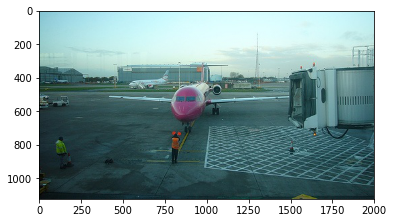

In [21]:
from matplotlib import pyplot as plt

x = train_images[0]
print('Input', x.shape)
x = x.astype('float32').transpose((2,0,1)).expand_dims(axis=0)/255

conv_trans = nn.Conv2DTranspose(
    3, in_channels=3, kernel_size=8, padding=2, strides=4)
conv_trans.initialize()
conv_trans(x)
conv_trans.weight.set_data(bilinear_kernel(3, 3, 8))


y = conv_trans(x)
y = y[0].clip(0,1).transpose((1,2,0))
print('Output', y.shape)

plt.imshow(y.asnumpy())
plt.show()

In [22]:
from mxnet import init

conv_trans = net[-1]
conv_trans.initialize(init=init.Zero())
net[-2].initialize(init=init.Xavier())

x = nd.zeros((batch_size, 3, *input_shape))
net(x)

shape = conv_trans.weight.data().shape
conv_trans.weight.set_data(bilinear_kernel(*shape[0:3]))

In [36]:
def _get_batch(batch, ctx):
    """return features and labels on ctx"""
    if isinstance(batch, mx.io.DataBatch):
        features = batch.data[0]
        labels = batch.label[0]
    else:
        features, labels = batch
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx),
            features.shape[0])

def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc = nd.array([0])
    n = 0
    if isinstance(data_iter, mx.io.MXDataIter):
        data_iter.reset()
    for batch in data_iter:
        features, labels, batch_size = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc += (net(X).argmax(axis=1)==y).sum().copyto(mx.cpu())
            n += y.size
        acc.wait_to_read() 
    return acc.asscalar() / n

def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs, print_batches=None):
    """Train and evaluate a model."""
    print("training on ", ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(1, num_epochs + 1):
        train_l_sum, train_acc_sum, n, m = 0.0, 0.0, 0.0, 0.0
        if isinstance(train_iter, mx.io.MXDataIter):
            train_iter.reset()
        start = time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            trainer.step(batch_size)
            n += batch_size
            m += sum([y.size for y in ys])
            if print_batches and (i+1) % print_batches == 0:
                print("batch %d, loss %f, train acc %f" % (
                    n, train_l_sum / n, train_acc_sum / m
                ))
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print("epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec" % (
            epoch, train_l_sum / n, train_acc_sum / m, test_acc, time() - start
        ))

In [41]:
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)

ctx = mx.gpu(0)
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': .1, 'wd':1e-3})

train(train_data, test_data, net, loss, trainer, ctx, num_epochs=10)

training on  gpu(0)
epoch 1, loss 1.5027, train acc 0.725, test acc 0.790, time 85.3 sec
epoch 2, loss 0.5697, train acc 0.833, test acc 0.835, time 75.3 sec
epoch 3, loss 0.4301, train acc 0.866, test acc 0.843, time 75.1 sec
epoch 4, loss 0.3734, train acc 0.880, test acc 0.847, time 75.4 sec
epoch 5, loss 0.3337, train acc 0.891, test acc 0.848, time 75.2 sec
epoch 6, loss 0.3024, train acc 0.900, test acc 0.852, time 75.1 sec
epoch 7, loss 0.2799, train acc 0.907, test acc 0.853, time 75.1 sec
epoch 8, loss 0.2648, train acc 0.912, test acc 0.856, time 75.1 sec
epoch 9, loss 0.2393, train acc 0.919, test acc 0.852, time 75.2 sec
epoch 10, loss 0.2233, train acc 0.924, test acc 0.856, time 75.4 sec


In [44]:
def predict(im):
    data = normalize_image(im)
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    yhat = net(data.as_in_context(ctx))
    pred = nd.argmax(yhat, axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

def label2image(pred):
    x = pred.astype('int32').asnumpy()
    cm = nd.array(colormap).astype('uint8')
    return nd.array(cm[x,:])

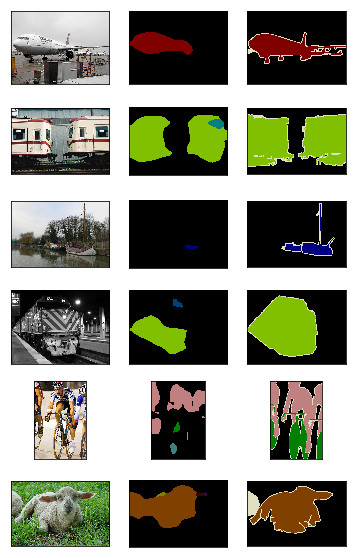

In [45]:
test_images, test_labels = read_images(train=False)

n = 6
imgs = []
for i in range(n):
    x = test_images[i]
    pred = label2image(predict(x))
    imgs += [x, pred, test_labels[i]]

show_images(imgs, nrows=n, ncols=3, figsize=(6,10))